In [1]:
import cv2     # for capturing videos
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import to_categorical
import numpy as np    
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

Using TensorFlow backend.


## Model evaluation from saved model (trained in google Colab)

In [2]:
# loading model:

from keras.models import model_from_json

model_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\results\\models"


json_file = open(model_dir +'\\model_LSTM_json.json')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_dir + '\\model_LSTM_weight.h5')
print("Loaded model from disk")

Loaded model from disk


In [3]:
# bring model

from keras.models import Sequential
from keras.layers import Conv2D, Dropout,Flatten, MaxPooling2D, BatchNormalization, TimeDistributed
from keras.layers import LSTM, Dense


n_timesteps = 10                                        
lstm_cells =5

model = Sequential()
model.add(TimeDistributed(Conv2D (16, (3,3), activation = 'relu'),
                                  input_shape = (n_timesteps, 250,250,3)))      
model.add(TimeDistributed(Conv2D (32, (3,3), activation = 'relu')))             
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling2D((2,2))))        
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(TimeDistributed(Flatten()))                                                     

model.add(LSTM(units = lstm_cells, return_sequences = True, dropout=0.1, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
#model.summary()

In [4]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

### To test this model with your test video:
1. put the test video in a directory--> change the test_video_dir path based on your directory 
2. define a directory for captured images --> change the path of test_img_dir
3. Check the frames. the number of frames need to be coefficient of 10. The reson is my input shape data for traning
so adjust the number of frames (either copy some frames or delet some so the len (os.listdir(test_img_dir)) = 10*n
4. do labeling in a csv file (same as the sample uploaded for my tets videos)
5. read the csv file as dataframe ( remember to rename the csv file path based on the name of your csv file)
6. if json file is needed remember to change the path file for saving timelabel.json / also change the vid_len parameter based on the time of the video you are testing
7. Run the rest of the code without change

In [211]:
test_video_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\test_video\\test"
test_img_dir = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\test_img\\test5"

In [175]:
def get_frames(video_path, dest_path):
    file_name = video_path.split('.')[0].split('\\')[-1]
    vidcap = cv2.VideoCapture(video_path)

    sec = 0
    frameRate = 0.5           #//it will capture image in each 0.5 second
    count = 1
    hasFrames = True
    while hasFrames:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            cv2.imwrite(dest_path+'\\'+file_name+'_'+ str(count)+".jpg", image)     # save frame as JPG file

        count = count + 1
        sec = sec + frameRate
        sec = round(sec, 2)

In [176]:
# getting captions from videos and put them in related derectories:

for i in range(len(os.listdir(test_video_dir))):
    video_path = test_video_dir + '\\' + os.listdir(test_video_dir)[i]
    dest_path = test_img_dir

    get_frames(video_path, dest_path)

In [7]:
'''
import os

test_label =[]
for file in os.listdir(test_img_dir):
    label = file.split('_')[0]
    if label == 'other':
        test_label.append(0)
    else:
        test_label.append(1)
print (len(test_label))
'''

200


In [212]:
# Testing long video consisting multiple actions

csv_path = "D:\\tamu\\courses\\DeepLearning\\ProjectPart4\\test_labels"

df = pd.read_csv(csv_path + "\\sample5.csv")
test_label = df ['Label'].tolist()

In [213]:
import glob
import cv2

def get_Xtrain(file_name):
    X_train = []
    for i , filename in enumerate(glob.glob(file_name)):
        image = cv2.imread(filename)
        res_img = cv2.resize(image, dsize=(250,250), interpolation=cv2.INTER_CUBIC)
        X_train.append(res_img)
    
    return X_train 

X_t = get_Xtrain(test_img_dir + '\\*.jpg')

In [214]:
import numpy as np

x_test = np.asarray(X_t)
y_test = np.asarray(test_label)

print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_test.shape:  (60, 250, 250, 3)
y_test.shape:  (60,)


In [215]:
x_test = x_test/x_test.max()      

In [216]:
x = []
y = []
for i in range(0, x_test.shape[0], 10):
    x.append(x_test[i:(i+10)])
    y.append(y_test[i:(i+10)])

x = np.asarray(x)
y = np.asarray(y)
print(x.shape)
print(y.shape)

x_test = x
y_test = y

(6, 10, 250, 250, 3)
(6, 10)


In [217]:
y_test = y_test.reshape(y_test.shape[0], 10,1)
print(y_test.shape)

(6, 10, 1)


In [218]:
scores = model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

6/6 [==============================] - 1s 193ms/step
accuracy: 58.33%


### Timelabel.json

In [219]:
predictions = model.predict(x= x_test)
len(predictions)

6

In [220]:
import json

vid_len = 30
n = len(X_t)

preds = predictions.reshape(len(X_t),)
test_label

json = "{\"push\":["
values = []
#time = 0
times = np.linspace(0.1,vid_len,n)

for i in range(len(preds)):
    l = "["
    #time += 0.5
    time = times[i]
    l += str(time)
    l += ','
    l += str(preds[i])
    l += "]"
    l += ","
    json += l

json = json[:-1]
    
json += "]}"


with open(model_dir+'\\timelabel_5_data.json', 'w') as f:
    f.write(json)

## Timelabel plot

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

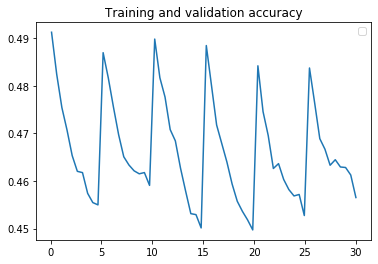

<Figure size 432x288 with 0 Axes>

In [221]:
#prediction = preds

# Plot Training and Validation accuracy over epoch
plt.plot(times, preds)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()